In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

204565269561.9463

In [59]:
shapenoise  = .1
sigma_int = .05
logm0 = 14
a = 1
proxy = np.sort(np.random.random(100)*(100-20) + 20)

In [60]:
def mu(proxy, logm0, a): return logm0 + a * np.log10(proxy/20)

In [61]:

u=np.random.randn(len(proxy))

In [62]:
model = mu(proxy, logm0, a)
data = model + (shapenoise**2 + sigma_int**2)**.5 * u

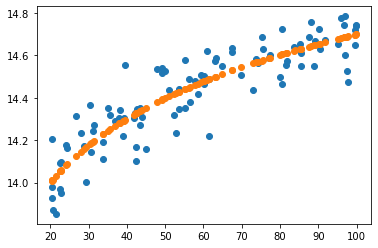

In [63]:
plt.scatter(proxy, data)
plt.scatter(proxy, model)

In [64]:
def lnL_1(thetaq):
    logm0p, ap, sigma_intp = thetaq
    if sigma_intp < 0: return -np.inf
    model = mu(proxy, logm0p, ap)
    delta = model-data
    errp = (shapenoise**2 + sigma_intp**2)**.5
    p = np.exp(-.5*(delta/errp)**2)/(np.sqrt(2*np.pi*errp**2))
    return np.sum(np.log(p))

In [65]:
def lnL_2(thetaq):
    u=np.random.randn(len(proxy))
    logm0p, ap, sigma_intp = thetaq
    if sigma_intp < 0: return -np.inf
    model = mu(proxy, logm0p, ap)
    delta = model - data + u*(sigma_intp**2)**.5
    err = (shapenoise**2)**.5
    p = np.exp(-.5*(delta/err)**2)/(np.sqrt(2*np.pi*err**2))
    return np.sum(np.log(p))

In [66]:
lnL_2([logm0, a, sigma_int])

75.59105762972371

In [67]:
lnL_1([logm0, a, sigma_int])

87.46307481261454

In [68]:
#from multiprocessing import Pool
nwalker=300
pos=.001*np.random.randn(nwalker,3) + np.array(np.array([logm0,a,sigma_int]))
sampler = emcee.EnsembleSampler(nwalker, 3, lnL_1,)
sampler.run_mcmc(pos, 500, progress=True);
flat_samples1 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 500/500 [00:06<00:00, 76.18it/s]


In [69]:
sampler = emcee.EnsembleSampler(nwalker, 3, lnL_2,)
sampler.run_mcmc(pos, 500, progress=True);
flat_samples2 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 500/500 [00:08<00:00, 59.40it/s]


In [70]:
flat_samples2

array([[1.39985155e+01, 9.99502495e-01, 4.90176103e-02],
       [1.40013387e+01, 9.99488633e-01, 4.88274746e-02],
       [1.39963593e+01, 9.93502552e-01, 3.87703904e-02],
       ...,
       [1.39996667e+01, 9.82961191e-01, 3.41460136e-02],
       [1.40052331e+01, 9.70313604e-01, 3.28845422e-02],
       [1.40229092e+01, 9.49317279e-01, 9.19168779e-03]])

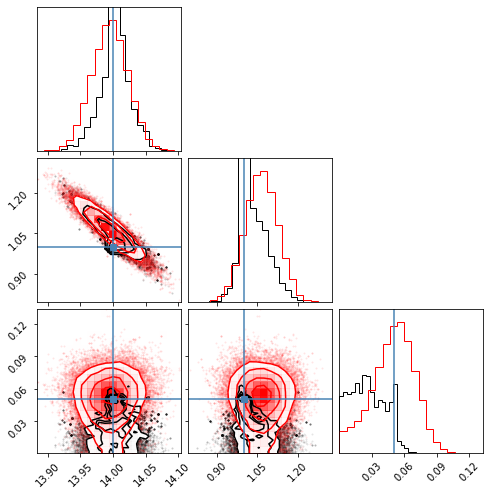

In [57]:
#fig, axs = plt.subplots(len(pos), len(pos), figsize = (7,7))
#fig = corner.corner(flat_samples1[:-2][4000:],  truths = [logm0, a, sigma_int], color='r')
fig = corner.corner(flat_samples2[flat_samples2[:,2]>0][15000:],  bins=20)#fig = fig,)
fig = corner.corner(flat_samples1[15000:], fig=fig, truths = [logm0, a, sigma_int], color='r',bins=20)

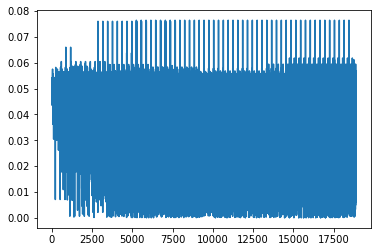

In [46]:
plt.plot(flat_samples2[:-2][:,2])

(array([1.900e+01, 1.230e+02, 3.790e+02, 1.026e+03, 5.192e+03, 5.655e+03,
        2.130e+03, 3.370e+02, 3.300e+01, 4.000e+00]),
 array([0.90593652, 0.94782344, 0.98971035, 1.03159726, 1.07348418,
        1.11537109, 1.157258  , 1.19914492, 1.24103183, 1.28291874,
        1.32480566]),
 <a list of 10 Patch objects>)

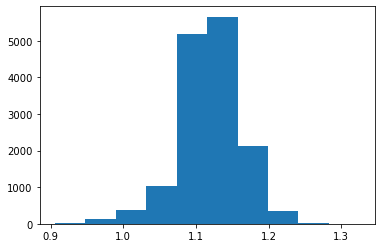

In [31]:
plt.hist(flat_samples2[:-2][4000:][:,1])